In [57]:
# Import des bibliothèques nécessaires
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
from nltk.corpus import stopwords 
from collections import Counter
from wordcloud import WordCloud

In [27]:
file_path = "Data/data_clean.csv" 
df = pd.read_csv(file_path)

In [28]:
def tokenizer(texte):
    # Supprimer les espaces inutiles et convertir en minuscule
    texte = texte.strip().lower()
    # Remplacer les ponctuations par un espace
    texte = re.sub(r"[,!?:;…’()/\.\-«»\n']", " ", texte)
    # Supprimer les espaces multiples
    tokens = re.split(r"\s+", texte)
    # Supprimer les tokens vides
    tokens = [token for token in tokens if token]
    return tokens

In [29]:
df['Niveau_difficultes']

0       boule au ventre
1     Passe non précise
2                  7/10
3                   NaN
4                   NaN
            ...        
85                  NaN
86                  NaN
87                  NaN
88               Jambes
89                  NaN
Name: Niveau_difficultes, Length: 90, dtype: object

In [45]:
df['Niveau_difficultes'] = df['Niveau_difficultes'].fillna("").astype(str)  # Remplace NaN par une chaîne vide
df['tokens'] = df['Niveau_difficultes'].apply(lambda x: ' '.join(tokenizer(x)))

# Vérifier que 'tokens' est bien une liste et non une chaîne de caractères
df['tokens'] = df['tokens'].apply(lambda x: x.split() if isinstance(x, str) else x)

In [46]:
def nb_mots(texte):
    return len(tokenizer(texte))

In [47]:
# Stopwords
stop_words_fr = stopwords.words('french')
stop_words_custom = [w for w in open("./Data/stopword.txt", encoding='utf-8').read().split(",")]
stop_words = set(stop_words_fr + stop_words_custom)

In [48]:
# Application du prétraitement
def retirer_stopwords(texte):
    texte = [i for i in texte if len(i) > 3 and i not in stop_words]  # Enlever les mots courts et les stopwords
    return texte

df['tokens_sans_stopwords'] = df['tokens'].apply(retirer_stopwords)

In [49]:
df.head()

,ID,Heure_debut,Heure_fin,Email,Initiales,Sexe,Date_naissance,Annee_debut_foot,Affirmation.1,Affirmation.12,...,Anxiete_avant_match,Difficultes_avant_match,Niveau_difficultes,Age,Nb_annee_foot,Temps_en_min,tokens,tokens_sans_stopwords,longueur,nb_mots
0,1,2025-02-24 14:25:10,2025-02-24 14:27:44,anonymous,CB,femme,2000-06-01,2021,Accord complet,Accord partiel,...,8,"Oui, au niveau corporel ( tensions, fatigue, c...",boule au ventre,25,4,2.57,"[boule, au, ventre]","[boule, ventre]",15,15
1,2,2025-02-24 14:34:21,2025-02-24 14:40:40,anonymous,OD,femme,2004-12-06,2018,Accord partiel,Accord partiel,...,7,"Oui, au niveau cognitif (concentration, prise ...",Passe non précise,21,7,6.32,"[passe, non, précise]","[passe, précise]",17,17
2,3,2025-02-24 17:56:05,2025-02-24 18:00:03,anonymous,SB,homme,2003-04-25,2010,Accord partiel,Accord partiel,...,8,"Oui, au niveau cognitif (concentration, prise ...",7/10,22,15,3.97,"[7, 10]",[],4,4
3,4,2025-02-24 18:01:06,2025-02-24 18:04:00,anonymous,LG,femme,2005-03-26,2019,Accord complet,Accord partiel,...,7,"Non, rien de particulier",,20,6,2.90,[],[],0,0
4,5,2025-02-24 18:50:56,2025-02-24 18:53:36,anonymous,SK,femme,2003-04-13,2006,Accord partiel,Accord partiel,...,6,"Non, rien de particulier",,22,19,2.67,[],[],0,0


In [51]:
# Exploration des données
print("\nAnalyse exploratoire :")
df['longueur'] = df['tokens_sans_stopwords'].apply(len)
print("Longueur moyenne des  par catégorie :")
print(df.groupby('Sexe')['longueur'].mean())


Analyse exploratoire :
Longueur moyenne des  par catégorie :
Sexe
femme    0.573171
homme    0.250000
Name: longueur, dtype: float64


In [52]:
# Fréquence des mots par catégorie
freq_par_categorie = {}

for categorie in df['Sexe'].unique():
    tous_les_mots = [mot for tokens in df[df['Sexe'] == categorie]['tokens_sans_stopwords'] for mot in tokens]
    freq_par_categorie[categorie] = Counter(tous_les_mots).most_common(10)

# Afficher les résultats
print("\nTop 10 des mots les plus fréquents par catégorie :")
for categorie, mots in freq_par_categorie.items():
    print(f"\nCatégorie : {categorie}")
    for mot, freq in mots:
        print(f"{mot}: {freq}")



Top 10 des mots les plus fréquents par catégorie :

Catégorie : femme
ventre: 3
prise: 2
stresse: 2
peur: 2
concentration: 2
stress: 2
difficulté: 2
boule: 1
passe: 1
précise: 1

Catégorie : homme
peur: 1
météo: 1


In [53]:
df['nb_mots'] = df['tokens_sans_stopwords'].apply(len)

In [54]:
# avec les stopword
print("Longueur moyenne des articles par catégorie :")
print(df.groupby('Sexe')['nb_mots'].mean())

Longueur moyenne des articles par catégorie :
Sexe
femme    0.573171
homme    0.250000
Name: nb_mots, dtype: float64


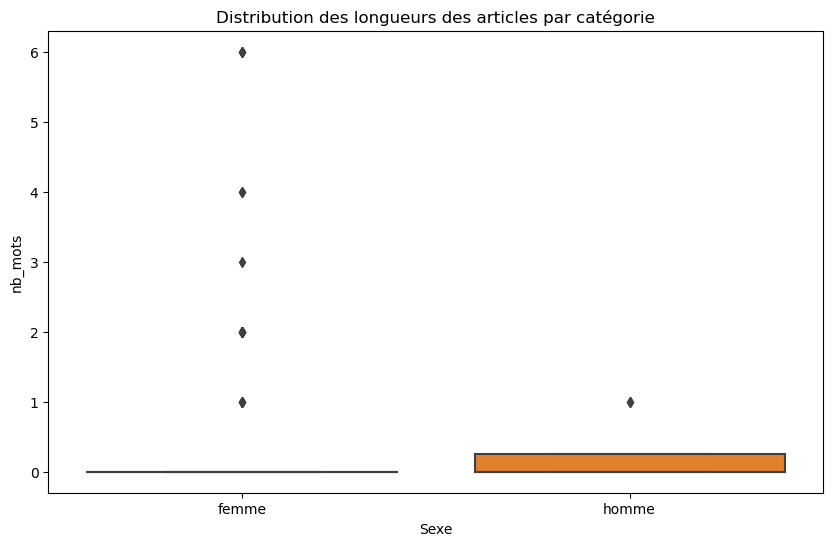

In [55]:
# Visualisation des distributions de longueur des articles
plt.figure(figsize=(10, 6))
sns.boxplot(x='Sexe', y='nb_mots', data=df)
plt.title('Distribution des longueurs des articles par catégorie')
plt.show()

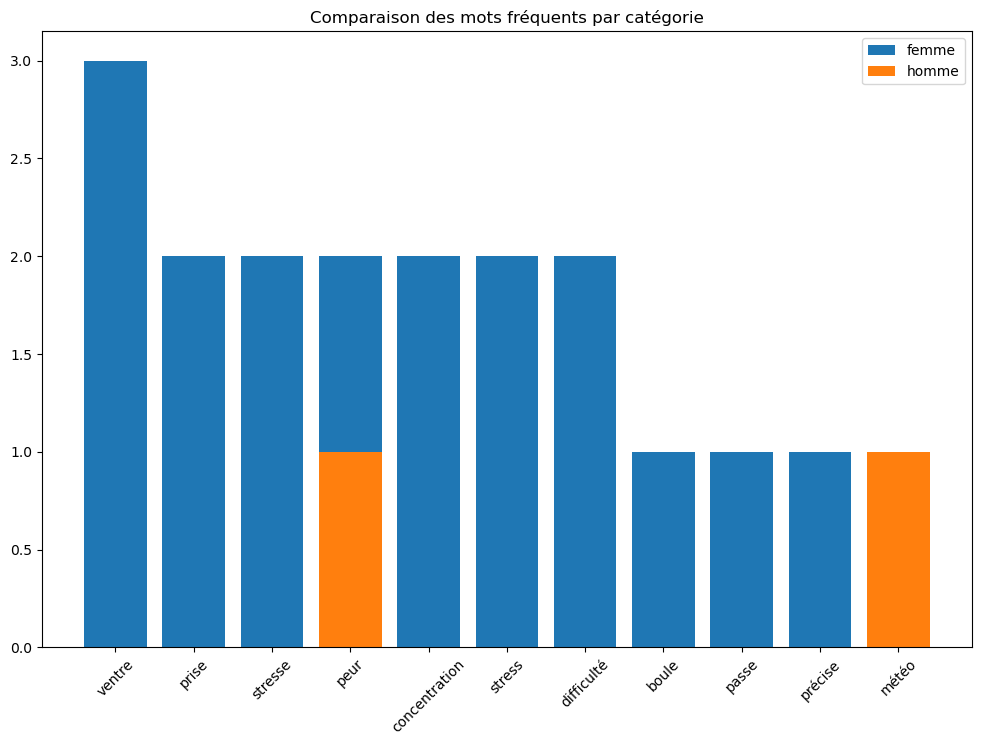

In [63]:
# Visualisation du champ lexical
plt.figure(figsize=(12, 8))
for categorie, mots in freq_par_categorie.items():
    mots_, frequences = zip(*mots)
    plt.bar(mots_, frequences, label=categorie)
plt.title("Comparaison des mots fréquents par catégorie")
plt.legend()
plt.xticks(rotation=45)
save_path = os.path.join("Image", "barplot_mots_sexe.png")
plt.savefig(save_path, dpi=300, bbox_inches="tight")
plt.show()


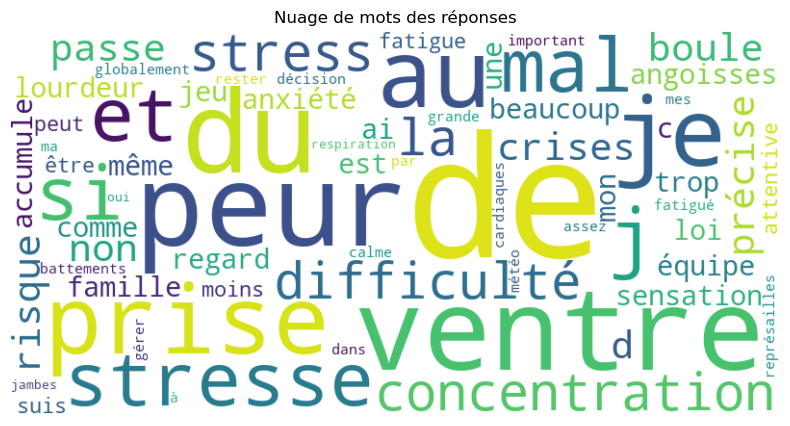

In [62]:
# Concaténer tous les mots de la colonne 'tokens' en une seule chaîne de texte
text = " ".join([" ".join(tokens) for tokens in df["tokens"] if isinstance(tokens, list)])

# Générer le wordcloud
wordcloud = WordCloud(width=800, height=400, background_color="white", colormap="viridis").generate(text)

# Afficher le nuage de mots
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")  # Supprimer les axes
plt.title("Nuage de mots des réponses")
save_path = os.path.join("Image", "all_wordcloud.png")
plt.savefig(save_path, dpi=300, bbox_inches="tight")
plt.show()

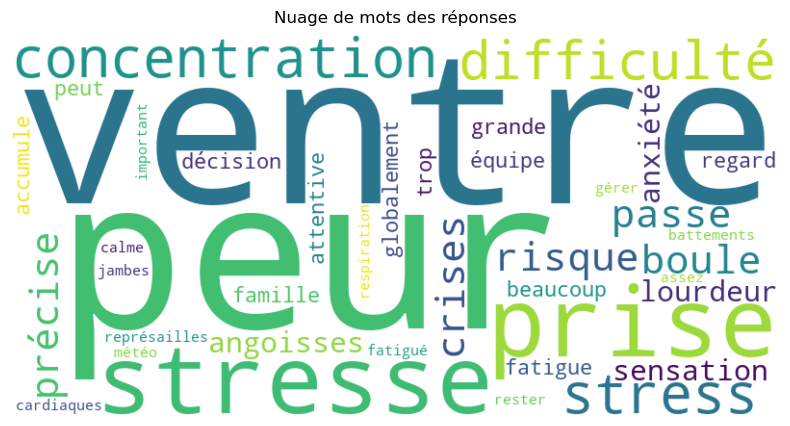

In [64]:
# Concaténer tous les mots de la colonne 'tokens' en une seule chaîne de texte
text = " ".join([" ".join(tokens) for tokens in df["tokens_sans_stopwords"] if isinstance(tokens, list)])

# Générer le wordcloud
wordcloud = WordCloud(width=800, height=400, background_color="white", colormap="viridis").generate(text)

# Afficher le nuage de mots
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")  # Supprimer les axes
plt.title("Nuage de mots des réponses")
save_path = os.path.join("Image", "all_wordcloud.png")
plt.savefig(save_path, dpi=300, bbox_inches="tight")
plt.show()

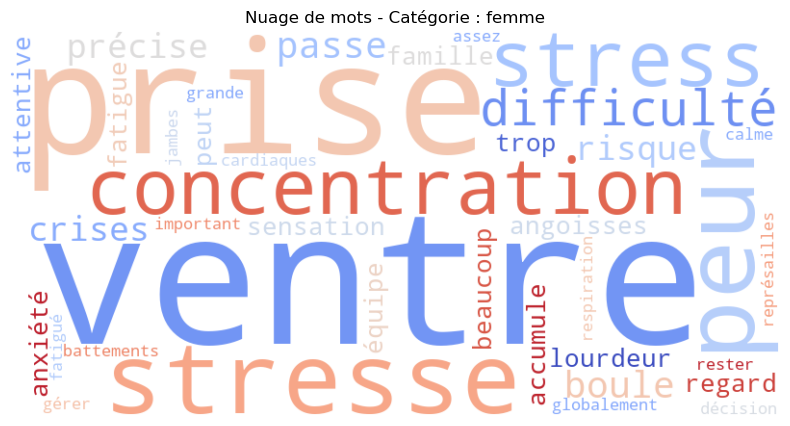

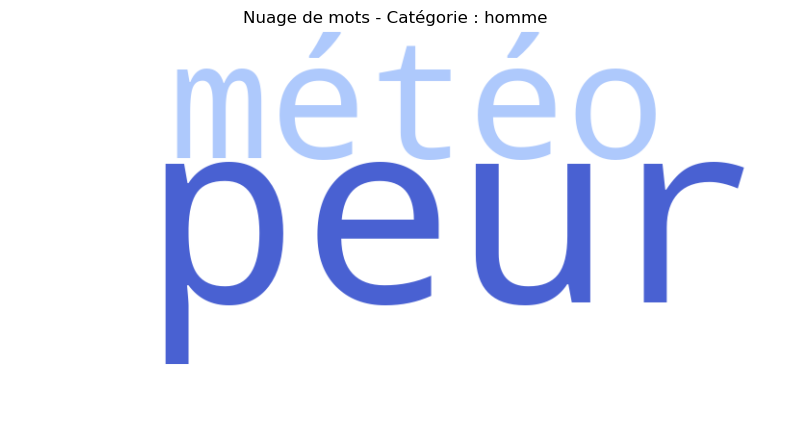

In [65]:
categories = df['Sexe'].unique()

for categorie in categories:
    # Filtrer les tokens pour la catégorie
    text = " ".join([" ".join(tokens) for tokens in df[df['Sexe'] == categorie]["tokens_sans_stopwords"] if isinstance(tokens, list)])

    # Générer le wordcloud
    wordcloud = WordCloud(width=800, height=400, background_color="white", colormap="coolwarm").generate(text)

    # Afficher
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Nuage de mots - Catégorie : {categorie}")
    save_path = os.path.join("Image", f"wordcloud_{categorie}.png")
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()
